In [3]:
% load_ext autoreload
% autoreload 2
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from copy import deepcopy

# adaptive-wavelets modules
from awd.data.biology import get_dataloader, load_pretrained_model
from awd.utils import tuple_to_tensor
from awd.trim import TrimModel

# evaluation
from ex_biology import p
from eval_biology import load_results, max_transformer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time

# load results

In [23]:
dirs = [
    "db5_saliency_warmstart_seed=1",
    "db5_saliency_warmstart_seed=10",
    "db5_saliency_warmstart_seed=100",
    "db5_saliency_warmstart_seed=1000",
    "db5_saliency_warmstart_seed=10000"
]
dics, results, models = load_results(dirs, include_interp_loss=False)

# prediction accuracy, compression, and computation time

In [39]:
def r2_bootstrap(y, y_pred, m=10000):
    """Return bootstrap mean and std error."""
    np.random.seed(p.seed)
    e = []
    for j in range(m):
        idx = np.arange(len(y))
        sel = np.random.choice(idx, len(idx), replace=True)
        e.append(metrics.r2_score(y[sel], y_pred[sel]))
    return metrics.r2_score(y_test, preds), np.std(e)

In [46]:
r = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],
    'LSTM': [],
}

s = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],
    'LSTM': [],
}

c = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': []
}

t = {
    'Standard Wavelet (DB5)': [],
    'AWD (Ours)': [],
    'LSTM': [],
}

best_lam = []
best_wt = []

# params for feature transformer
sgn = "pos"
m = 6

for index in range(len(dirs)):
    res = results[index]
    mos = models[index]

    # load data
    (train_loader, test_loader) = get_dataloader(p.data_path,
                                                 batch_size=p.batch_size,
                                                 is_continuous=True)

    # cross validation
    reg_score = []

    for i, wt in enumerate(list(dics[index]['wt'].values())):
        wt = wt.to('cpu')
        (X, y), (X_test, y_test) = max_transformer(wt,
                                                   train_loader,
                                                   test_loader,
                                                   sgn=sgn,
                                                   m=m)

        clf = LinearRegression()
        scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
        reg_score.append(scores.mean())
    reg_score = np.array(reg_score)

    # select best wavelet
    idx1, idx2 = list(dics[index]['wt'].keys())[np.argmax(reg_score).flatten()[0]]
    idx = dics[index]['index'][(idx1, idx2)]
    lamL1wave = dics[index]['lamL1wave'][(idx1, idx2)]
    lamL1attr = dics[index]['lamL1attr'][(idx1, idx2)]
    best_lam.append((lamL1wave, lamL1attr))
    wt = dics[index]['wt'][(idx1, idx2)]
    best_wt.append(wt)

    # load pre-trained model
    model = load_pretrained_model(p.model_path, device=device)

    p.batch_size = 3000
    (train_loader, test_loader) = get_dataloader(p.data_path,
                                                 batch_size=p.batch_size,
                                                 is_continuous=True)

    (X, y), (X_test, y_test) = max_transformer(wt,
                                               train_loader,
                                               test_loader,
                                               sgn=sgn,
                                               m=m)

    clf = LinearRegression().fit(X, y)
    start_time = time.time()
    preds = clf.predict(X_test)
    t['AWD (Ours)'].append(time.time() - start_time)
    acc, std = r2_bootstrap(y_test, preds)
    r['AWD (Ours)'].append(acc)
    s['AWD (Ours)'].append(std)

    wt_o = adaptive_wavelets.DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0.0)
    (X, y), (X_test, y_test) = max_transformer(wt_o,
                                               train_loader,
                                               test_loader,
                                               sgn=sgn,
                                               m=m)

    clf_o = LinearRegression().fit(X, y)
    start_time = time.time()
    preds = clf_o.predict(X_test)
    t['Standard Wavelet (DB5)'].append(time.time() - start_time)
    acc, std = r2_bootstrap(y_test, preds)
    r['Standard Wavelet (DB5)'].append(acc)
    s['Standard Wavelet (DB5)'].append(std)

    preds = []
    y_test = []
    start_time = time.time()
    for data, labels in test_loader:
        preds.append(model(data).detach().numpy())
        y_test.append(labels.detach().numpy())
    t['LSTM'].append(time.time() - start_time)
    preds = np.vstack(preds)
    y_test = np.vstack(y_test)
    acc, std = r2_bootstrap(y_test, preds)
    r['LSTM'].append(acc)
    s['LSTM'].append(std)

    # define trim model
    mt = TrimModel(model, wt.inverse, use_residuals=True)
    mt_o = TrimModel(model, wt_o.inverse, use_residuals=True)
    attributer = adaptive_wavelets.Attributer(mt, attr_methods='Saliency', device='cuda')
    attributer_o = adaptive_wavelets.Attributer(mt_o, attr_methods='Saliency', device='cuda')

    # compute compression rate and representations
    attrs = {'AWD': torch.tensor([]).to(device),
             'DB5': torch.tensor([]).to(device)}
    reps = {'AWD': torch.tensor([]).to(device),
            'DB5': torch.tensor([]).to(device)}
    wt, wt_o = wt.to(device), wt_o.to(device)
    for data, _ in test_loader:
        data = data.to(device)
        i = 0
        for w in [wt, wt_o]:
            if i == 0:
                data_t = w(data)
                with torch.backends.cudnn.flags(enabled=False):
                    attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
                y, _ = tuple_to_tensor(data_t)
                reps['AWD'] = torch.cat((reps['AWD'], y), dim=0)
                z, _ = tuple_to_tensor(attributions)
                attrs['AWD'] = torch.cat((attrs['AWD'], z), dim=0)
            else:
                data_t = w(data)
                with torch.backends.cudnn.flags(enabled=False):
                    attributions = attributer_o(data_t, target=0, additional_forward_args=deepcopy(data))
                y, _ = tuple_to_tensor(data_t)
                reps['DB5'] = torch.cat((reps['DB5'], y), dim=0)
                z, _ = tuple_to_tensor(attributions)
                attrs['DB5'] = torch.cat((attrs['DB5'], z), dim=0)
            i += 1
    reps['AWD'] = reps['AWD'].reshape(-1)
    reps['DB5'] = reps['DB5'].reshape(-1)
    attrs['AWD'] = attrs['AWD'].reshape(-1)
    attrs['DB5'] = attrs['DB5'].reshape(-1)

    thresh1 = 1e-3
    thresh2 = 1e-3
    c_rate_AWD = 1.0 * ((abs(reps['AWD']) > thresh1) & (abs(attrs['AWD']) > thresh2)).sum() / reps['AWD'].shape[0]
    c_rate_DB5 = 1.0 * ((abs(reps['DB5']) > thresh1) & (abs(attrs['DB5']) > thresh2)).sum() / reps['DB5'].shape[0]
    c['AWD (Ours)'].append(c_rate_AWD.item())
    c['Standard Wavelet (DB5)'].append(c_rate_DB5.item())

    print(idx1, reg_score[idx1])

4 0.2364324511728789
4 0.23637966230362312
4 0.23653587340757604
4 0.23602692316608587
4 0.23631625309022758


In [47]:
print("Acc  :", np.array(r['AWD (Ours)']).mean().round(3), np.array(r['Standard Wavelet (DB5)']).mean().round(3),
      np.array(r['LSTM']).mean().round(3))
print("Std  :", np.array(r['AWD (Ours)']).std().round(3))
print("Comp :", np.array(c['AWD (Ours)']).mean().round(3), np.array(c['Standard Wavelet (DB5)']).mean().round(3))
print("Std  :", np.array(c['AWD (Ours)']).std().round(3))
print("Time :", np.array(t['AWD (Ours)']).mean().round(4), np.array(t['Standard Wavelet (DB5)']).mean().round(4),
      np.array(t['LSTM']).mean().round(4))
print("Std  :", np.array(t['AWD (Ours)']).std().round(4))

Acc  : 0.231 0.197 0.237
Std  : 0.001
Comp : 0.651 0.704
Std  : 0.003
Time : 0.0003 0.0003 0.073
Std  : 0.0


# plot wavelets

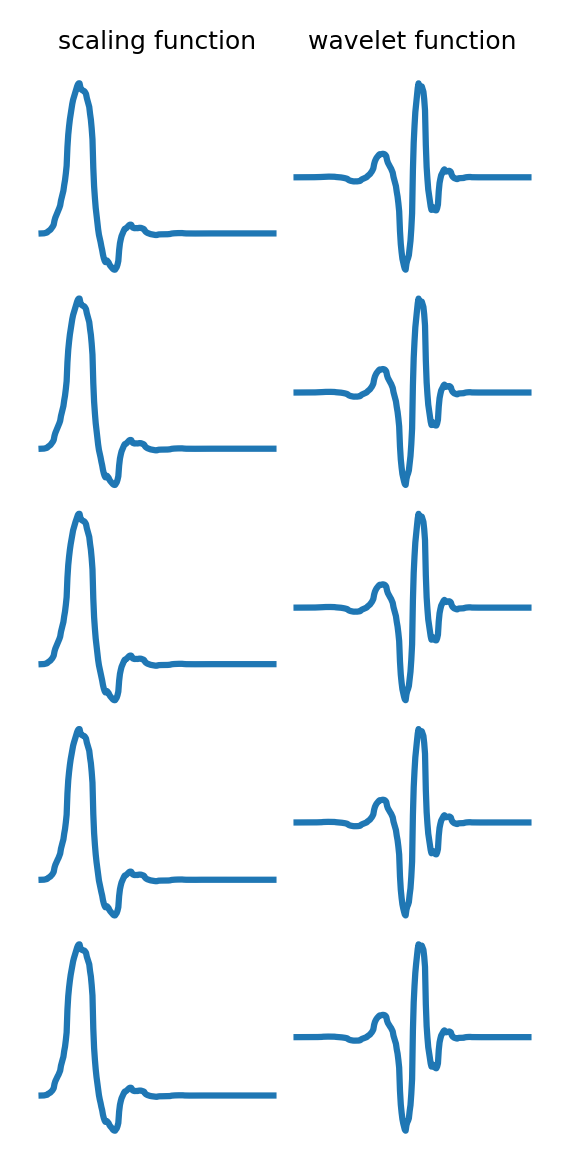

In [43]:
# plot
num_rows = 5
num_cols = 2
titsize = 6

fig = plt.figure(dpi=300, figsize=(2, 4))

for j in range(len(dirs)):
    wt = best_wt[j]
    phi, psi, x = adaptive_wavelets.get_wavefun(wt)

    plt.subplot(num_rows, num_cols, j * num_cols + 1)
    plt.plot(x, phi)
    plt.axis('off')
    if j == 0:
        plt.title('scaling function', fontsize=titsize)

    plt.subplot(num_rows, num_cols, j * num_cols + 2)
    plt.plot(x, psi)
    plt.axis('off')
    if j == 0:
        plt.title('wavelet function', fontsize=titsize)

plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.05)

# plt.savefig('figures/bio_wave.pdf', bbox_inches='tight')